Using device: cuda
Example 3.1: u = sin(πx₁)sin(πx₂)/(2π²)

Training DRM solver...
Epoch 500/3000 | Loss: -8.920650e-02
Epoch 1000/3000 | Loss: -8.688609e-02
Epoch 1500/3000 | Loss: -1.138007e-01
Epoch 2000/3000 | Loss: -1.474286e-01
Epoch 2500/3000 | Loss: -1.711468e-01
Epoch 3000/3000 | Loss: -1.801167e-01

Evaluating on grid...


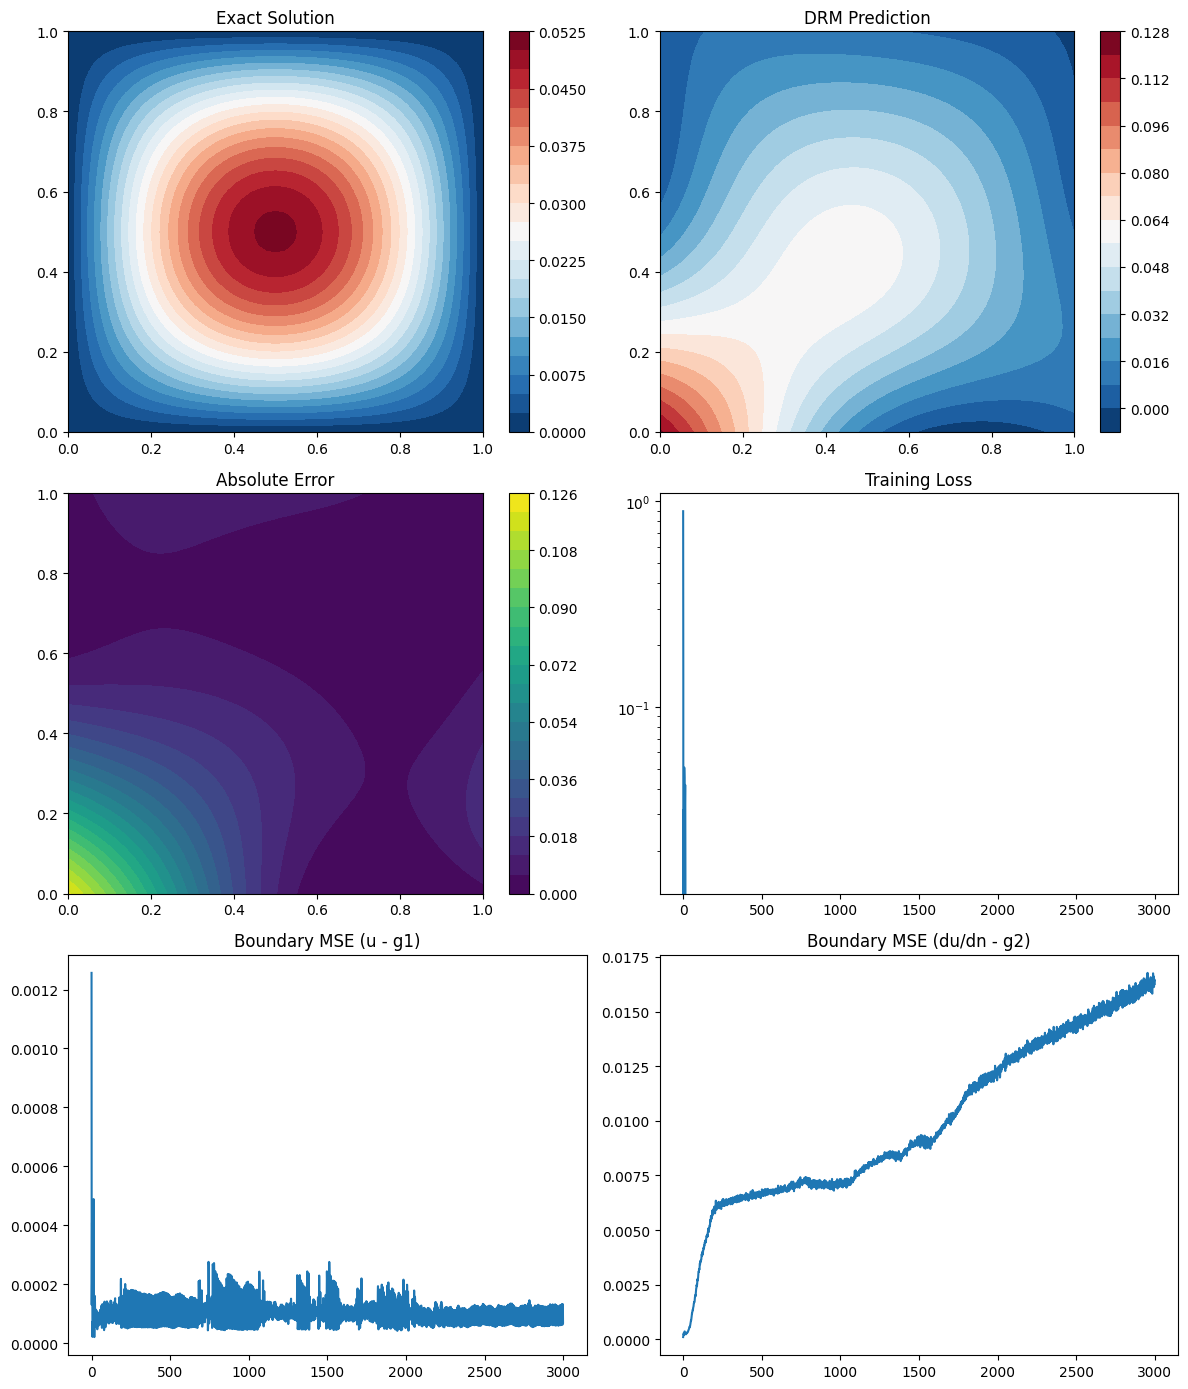

In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class NeuralNetwork(nn.Module):
    """Deep neural network for approximating u_theta"""
    def __init__(self, input_dim=2, output_dim=1, layers=4, hidden_dim=64):
        super(NeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        layer_list = []
        layer_list.append(nn.Linear(input_dim, hidden_dim))
        layer_list.append(nn.Tanh())
        
        for _ in range(layers - 2):
            layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(nn.Tanh())
        
        layer_list.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layer_list)
    
    def forward(self, x):
        return self.net(x)

class BiharmonicP3Solver:
    """Deep Ritz Method solver for P3: simply supported boundary conditions"""
    def __init__(self, network, num_domain=1000, num_boundary=500, 
                 penalty=1e3, lr=1e-3):
        self.u_theta = network.to(device)
        self.num_domain = num_domain
        self.num_boundary = num_boundary
        self.penalty = penalty
        self.optimizer = torch.optim.Adam(self.u_theta.parameters(), lr=lr)
        self.history = []
        self.mse_boundary_u_hist = []
        self.mse_boundary_du_hist = []
    
    def sample_interior(self, n_samples):
        X = torch.rand(n_samples, 2, device=device)
        X.requires_grad_(True)
        return X
    
    def sample_boundary(self, n_samples):
        Y = torch.zeros(n_samples, 2, device=device)
        samples_per_edge = n_samples // 4
        
        for edge in range(4):
            start_idx = edge * samples_per_edge
            end_idx = start_idx + samples_per_edge
            
            t = torch.rand(samples_per_edge, device=device)
            bias = 0.3
            t = t * (1 - bias) + 0.5 * bias + (t - 0.5) * (1 - bias) * torch.sign(t - 0.5)
            t = torch.clamp(t, 0, 1)
            
            if edge == 0:
                Y[start_idx:end_idx, 0] = 0.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 1:
                Y[start_idx:end_idx, 0] = 1.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 2:
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 0.0
            else:
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 1.0
        
        Y.requires_grad_(True)
        return Y
    
    def compute_laplacian(self, u, x):
        grad_u = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(grad_u[:, 0].sum(), x, create_graph=True, retain_graph=True)[0][:, 0]
        u_yy = torch.autograd.grad(grad_u[:, 1].sum(), x, create_graph=True, retain_graph=True)[0][:, 1]
        return u_xx + u_yy
    
    def compute_normal_derivative(self, u, y):
        grad_u = torch.autograd.grad(u.sum(), y, create_graph=True, retain_graph=True)[0]
        n_vec = torch.zeros_like(grad_u)
        
        tol = 1e-6
        
        mask = y[:, 0] < tol
        n_vec[mask, 0] = -1.0
        
        mask = y[:, 0] > 1.0 - tol
        n_vec[mask, 0] = 1.0
        
        mask = y[:, 1] < tol
        n_vec[mask, 1] = -1.0
        
        mask = y[:, 1] > 1.0 - tol
        n_vec[mask, 1] = 1.0
        
        return (grad_u * n_vec).sum(dim=1)
    
    def empirical_loss(self, X, Y, f, g1, g2):
        u_X = self.u_theta(X)
        lap_X = self.compute_laplacian(u_X, X)
        
        B_u_X = 0.5 * lap_X**2 - f(X) * u_X.squeeze()
        domain_loss = B_u_X.mean()

        u_Y = self.u_theta(Y).squeeze()
        du_dn_Y = self.compute_normal_derivative(u_Y, Y)
        
        boundary_g2_term = -g2(Y) * du_dn_Y
        boundary_penalty = (self.penalty / 2) * (u_Y - g1(Y))**2
        boundary_loss = (boundary_g2_term + boundary_penalty).mean()

        # ---------------------------
        # ADD MSE LOSSES (as requested)
        # ---------------------------
        mse_u_boundary = torch.mean((u_Y - g1(Y))**2)
        mse_du_boundary = torch.mean((du_dn_Y - g2(Y))**2)

        # store history
        self.mse_boundary_u_hist.append(mse_u_boundary.item())
        self.mse_boundary_du_hist.append(mse_du_boundary.item())

        total_loss = domain_loss + boundary_loss + mse_u_boundary + mse_du_boundary
        return total_loss, domain_loss, boundary_loss
    
    def train(self, f, g1, g2, epochs=500):
        for epoch in range(epochs):
            X = self.sample_interior(self.num_domain)
            Y = self.sample_boundary(self.num_boundary)
            
            self.optimizer.zero_grad()
            
            loss, loss_domain, loss_boundary = self.empirical_loss(X, Y, f, g1, g2)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.u_theta.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            self.history.append(loss.item())
            
            if (epoch + 1) % 500 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6e}")
    
    def evaluate(self, x_test):
        x_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
        with torch.no_grad():
            return self.u_theta(x_tensor).cpu().numpy()

# Example 3.1
print("=" * 70)
print("Example 3.1: u = sin(πx₁)sin(πx₂)/(2π²)")
print("=" * 70)

def u_exact(x):
    return np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1]) / (2 * np.pi**2)

def f(x):
    x_np = x.detach().cpu().numpy()
    return torch.tensor(4 * np.pi**4 * np.sin(np.pi * x_np[:, 0]) * 
                      np.sin(np.pi * x_np[:, 1]) / (2 * np.pi**2), 
                      dtype=torch.float32, device=device)

def g1(y):
    y_np = y.detach().cpu().numpy()
    return torch.tensor(u_exact(y_np), dtype=torch.float32, device=device).squeeze()

def g2(y):
    y_np = y.detach().cpu().numpy()
    return torch.tensor(-2 * np.pi**2 * np.sin(np.pi * y_np[:, 0]) * 
                       np.sin(np.pi * y_np[:, 1]) / (2 * np.pi**2),
                      dtype=torch.float32, device=device)

network = NeuralNetwork(layers=5, hidden_dim=128)
solver = BiharmonicP3Solver(network, num_domain=8000, num_boundary=3000, penalty=1e3, lr=1e-4)

print("\nTraining DRM solver...")
solver.train(f, g1, g2, epochs=3000)

print("\nEvaluating on grid...")
x = np.linspace(0, 1, 51)
y = np.linspace(0, 1, 51)
X_grid, Y_grid = np.meshgrid(x, y)
X_test = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

u_pred = solver.evaluate(X_test).reshape(X_grid.shape)
u_exact_grid = u_exact(X_test).reshape(X_grid.shape)
error = np.abs(u_pred - u_exact_grid)

# ------------------------
# VISUALIZATION WITH MSE
# ------------------------
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

im0 = axes[0, 0].contourf(X_grid, Y_grid, u_exact_grid, 20, cmap='RdBu_r')
axes[0, 0].set_title('Exact Solution')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].contourf(X_grid, Y_grid, u_pred, 20, cmap='RdBu_r')
axes[0, 1].set_title('DRM Prediction')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[1, 0].contourf(X_grid, Y_grid, error, 20, cmap='viridis')
axes[1, 0].set_title('Absolute Error')
plt.colorbar(im2, ax=axes[1, 0])

axes[1, 1].semilogy(solver.history)
axes[1, 1].set_title("Training Loss")

axes[2, 0].plot(solver.mse_boundary_u_hist)
axes[2, 0].set_title("Boundary MSE (u - g1)")

axes[2, 1].plot(solver.mse_boundary_du_hist)
axes[2, 1].set_title("Boundary MSE (du/dn - g2)")

plt.tight_layout()
plt.savefig("example_3_1_results.png", dpi=150)
plt.show()


In [34]:
import numpy as np

def compute_error_metrics(u_exact_grid, u_pred_grid, dx=1.0/50):
    """
    Compute L2, H1, and H2 error metrics and their relative versions.
    
    Parameters:
    -----------
    u_exact_grid : ndarray
        Exact solution on grid (shape: grid_size x grid_size)
    u_pred_grid : ndarray
        Predicted solution on grid (shape: grid_size x grid_size)
    dx : float
        Grid spacing (default: 1/50 for 51x51 grid)
    
    Returns:
    --------
    dict : Dictionary containing all error metrics
    """
    
    # Pointwise error
    error = np.abs(u_exact_grid - u_pred_grid)
    
    # =========================================================================
    # L2 ERRORS
    # =========================================================================
    # L2 error: ||u - u_θ||_L2(Ω)
    error_L2 = np.sqrt(np.sum(error**2) * dx**2)
    
    # L2 norm of exact solution: ||u||_L2(Ω)
    norm_u_L2 = np.sqrt(np.sum(u_exact_grid**2) * dx**2)
    
    # L2 relative error: ||u - u_θ||_L2 / ||u||_L2
    l2_relative = error_L2 / norm_u_L2
    
    # =========================================================================
    # H1 ERRORS (includes gradients)
    # =========================================================================
    # Compute gradients
    grad_u_exact = np.gradient(u_exact_grid, dx, axis=[0, 1])
    grad_u_pred = np.gradient(u_pred_grid, dx, axis=[0, 1])
    
    # Gradient error: ||∇(u - u_θ)||_L2(Ω)
    grad_error = np.sqrt(np.sum((grad_u_exact[0] - grad_u_pred[0])**2 + 
                                 (grad_u_exact[1] - grad_u_pred[1])**2) * dx**2)
    
    # Energy error: ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2
    energy_error = error_L2 + grad_error
    
    # L2 norm of gradient: ||∇u||_L2(Ω)
    norm_grad_u_L2 = np.sqrt(np.sum(grad_u_exact[0]**2 + grad_u_exact[1]**2) * dx**2)
    
    # H1 norm: ||u||_H1(Ω) = ||u||_L2 + ||∇u||_L2
    norm_u_H1 = norm_u_L2 + norm_grad_u_L2
    
    # H1 relative error: (||u - u_θ||_L2 + ||∇(u - u_θ)||_L2) / (||u||_L2 + ||∇u||_L2)
    h1_relative = energy_error / norm_u_H1
    
    # =========================================================================
    # H2 ERRORS (includes second derivatives)
    # =========================================================================
    # Compute second derivatives
    hess_u_exact_xx = np.gradient(grad_u_exact[0], dx, axis=0)
    hess_u_exact_yy = np.gradient(grad_u_exact[1], dx, axis=1)
    hess_u_pred_xx = np.gradient(grad_u_pred[0], dx, axis=0)
    hess_u_pred_yy = np.gradient(grad_u_pred[1], dx, axis=1)
    
    # Second derivative error: ||D²(u - u_θ)||_L2(Ω)
    second_deriv_error = np.sqrt(np.sum((hess_u_exact_xx - hess_u_pred_xx)**2 + 
                                         (hess_u_exact_yy - hess_u_pred_yy)**2) * dx**2)
    
    # H2 error: ||u - u_θ||_H2(Ω)
    h2_error = np.sqrt(error_L2**2 + grad_error**2 + second_deriv_error**2)
    
    # L2 norm of second derivatives: ||D²u||_L2(Ω)
    norm_second_deriv_u_L2 = np.sqrt(np.sum(hess_u_exact_xx**2 + hess_u_exact_yy**2) * dx**2)
    
    # H2 norm: ||u||_H2(Ω) = ||u||_L2 + ||∇u||_L2 + ||D²u||_L2
    norm_u_H2 = norm_u_L2 + norm_grad_u_L2 + norm_second_deriv_u_L2
    
    # H2 relative error: ||u - u_θ||_H2 / ||u||_H2
    h2_relative = h2_error / norm_u_H2
    
    # =========================================================================
    # Return all metrics as dictionary
    # =========================================================================
    metrics = {
        # L2 Errors
        'error_L2': error_L2,
        'l2_relative': l2_relative,
        
        # H1 Errors (Energy)
        'energy_error': energy_error,
        'h1_relative': h1_relative,
        
        # H2 Errors
        'h2_error': h2_error,
        'h2_relative': h2_relative,
        
        # Norms
        'norm_u_L2': norm_u_L2,
        'norm_grad_u_L2': norm_grad_u_L2,
        'norm_second_deriv_u_L2': norm_second_deriv_u_L2,
        'norm_u_H1': norm_u_H1,
        'norm_u_H2': norm_u_H2,
        
        # Component errors
        'grad_error': grad_error,
        'second_deriv_error': second_deriv_error,
        
        # Additional
        'max_error': np.max(error),
        'mean_error': np.mean(error)
    }
    
    return metrics


def print_error_report(metrics):
    """
    Print a formatted error report.
    
    Parameters:
    -----------
    metrics : dict
        Dictionary returned from compute_error_metrics()
    """
    print("\n" + "=" * 70)
    print("ERROR METRICS REPORT")
    print("=" * 70)
    
    print(f"\nL² ERRORS:")
    print(f"  ||u - u_θ||_L2(Ω):           {metrics['error_L2']:.6e}")
    print(f"  L² Relative Error:           {metrics['l2_relative']:.6e}")
    
    print(f"\nENERGY/H¹ ERRORS:")
    print(f"  ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2:  {metrics['energy_error']:.6e}")
    print(f"  H¹ Relative Error:                    {metrics['h1_relative']:.6e}")
    
    print(f"\nH² ERRORS:")
    print(f"  ||u - u_θ||_H2(Ω):           {metrics['h2_error']:.6e}")
    print(f"  H² Relative Error:           {metrics['h2_relative']:.6e}")
    
    print(f"\nADDITIONAL METRICS:")
    print(f"  Maximum Absolute Error:      {metrics['max_error']:.6e}")
    print(f"  Mean Absolute Error:         {metrics['mean_error']:.6e}")
    print("=" * 70)


# =========================================================================
# USAGE EXAMPLE
# =========================================================================
if __name__ == "__main__":
    # Example: Generate synthetic data
    x = np.linspace(0, 1, 51)
    y = np.linspace(0, 1, 51)
    X_grid, Y_grid = np.meshgrid(x, y)
    
    # Exact solution
    u_exact_grid = np.sin(np.pi * X_grid) * np.sin(np.pi * Y_grid) / (2 * np.pi**2)
    
    # Predicted solution (with small noise for demonstration)
    u_pred_grid = u_exact_grid + 0.001 * np.random.randn(*u_exact_grid.shape)
    
    # Compute metrics
    metrics = compute_error_metrics(u_exact_grid, u_pred_grid, dx=1.0/50)
    
    # Print report
    print_error_report(metrics)
    
    # Access individual metrics
    print(f"\nDirect access example:")
    print(f"L2 Relative Error: {metrics['l2_relative']:.6e}")
    print(f"H1 Relative Error: {metrics['h1_relative']:.6e}")
    print(f"H2 Relative Error: {metrics['h2_relative']:.6e}")


ERROR METRICS REPORT

L² ERRORS:
  ||u - u_θ||_L2(Ω):           1.009713e-03
  L² Relative Error:           3.986189e-02

ENERGY/H¹ ERRORS:
  ||u - u_θ||_L2 + ||∇(u - u_θ)||_L2:  5.465425e-02
  H¹ Relative Error:                    3.903232e-01

H² ERRORS:
  ||u - u_θ||_H2(Ω):           2.386083e+00
  H² Relative Error:           4.838695e+00

ADDITIONAL METRICS:
  Maximum Absolute Error:      3.643035e-03
  Mean Absolute Error:         7.926688e-04

Direct access example:
L2 Relative Error: 3.986189e-02
H1 Relative Error: 3.903232e-01
H2 Relative Error: 4.838695e+00


Using device: cuda

Training DRM solver...
Epoch 1/3000 | Loss: 4.494311e+00 | Domain: 4.485175e-04 | Boundary: 4.384278e+00 | LR: 1.000e-02
Epoch 500/3000 | Loss: 1.559597e-01 | Domain: 5.742711e-03 | Boundary: 9.453363e-02 | LR: 9.000e-03
Epoch 1000/3000 | Loss: 1.144064e-01 | Domain: -1.283784e-04 | Boundary: 8.717338e-03 | LR: 8.100e-03
Epoch 1500/3000 | Loss: 7.829635e-02 | Domain: 3.563668e-03 | Boundary: 4.441882e-03 | LR: 7.290e-03
Epoch 2000/3000 | Loss: 5.674051e-02 | Domain: 5.545802e-03 | Boundary: 5.546783e-04 | LR: 6.561e-03
Epoch 2500/3000 | Loss: 5.540557e-02 | Domain: 3.778544e-03 | Boundary: 2.168931e-03 | LR: 5.905e-03
Epoch 3000/3000 | Loss: 1.536653e-01 | Domain: -2.847040e-03 | Boundary: 6.933024e-02 | LR: 5.314e-03


Loaded best model from epoch 2930 with loss: -1.039720e-03

Evaluating on grid...

RESULTS (Best Model)
  ||u - u_theta||_L2: 5.714645e-04
  L2 relative:        3.600227e-01
  Energy error (L2+H1): 6.661437e-03
  H1 relative:        7.128536e-01
  H2

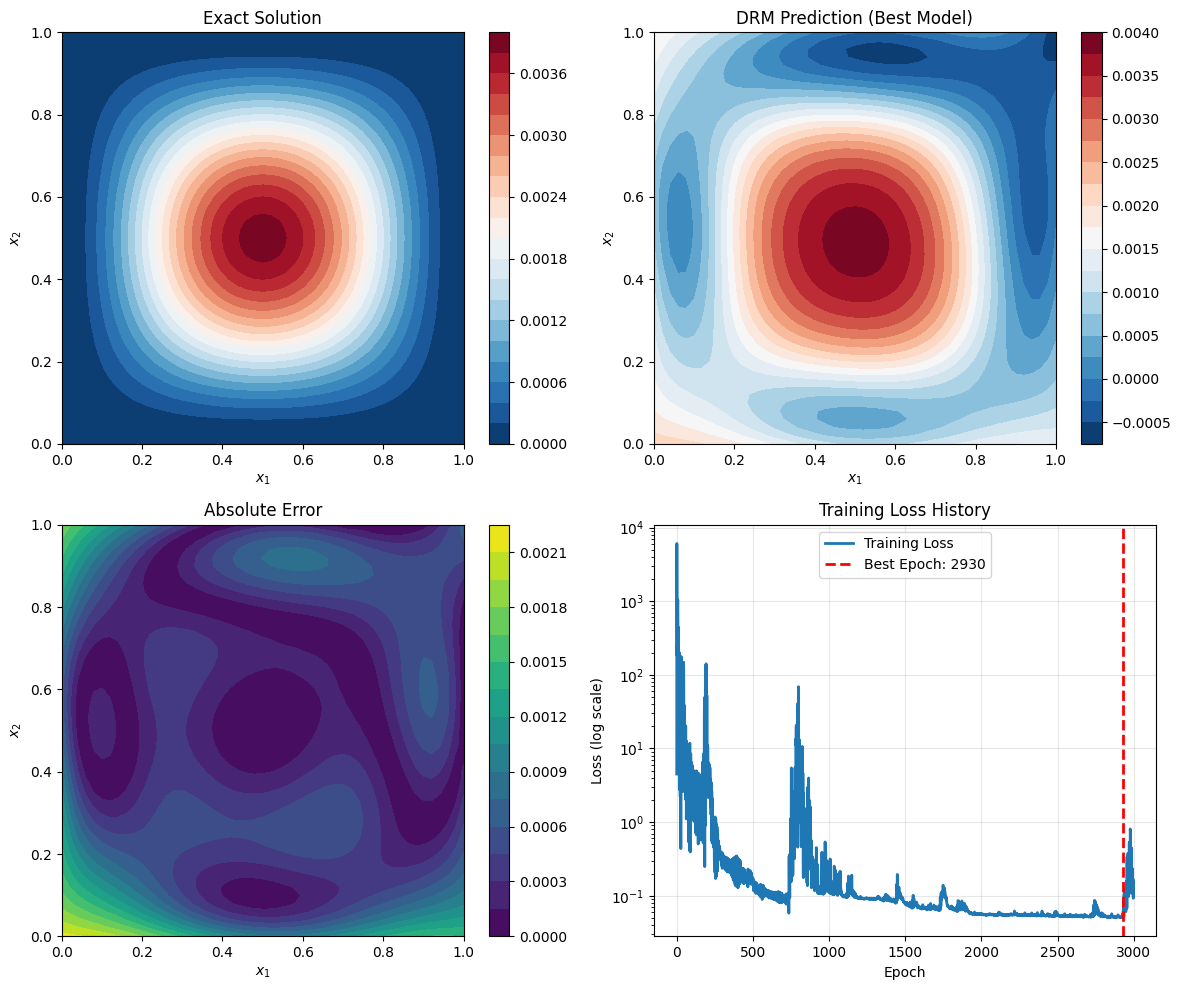

In [44]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy

# --------------------------------------------------------------
# Device
# --------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------------------------------------
# Neural network
# --------------------------------------------------------------
class NeuralNetwork(nn.Module):
    """Deep neural network for approximating u_theta"""
    def __init__(self, input_dim=2, output_dim=1, layers=4, hidden_dim=64):
        super(NeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        layer_list = []
        layer_list.append(nn.Linear(input_dim, hidden_dim))
        layer_list.append(nn.Tanh())

        for _ in range(layers - 2):
            layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(nn.Tanh())

        layer_list.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.net(x)

# --------------------------------------------------------------
# Solver (Deep Ritz / Deep Ritz-like energy for biharmonic)
# --------------------------------------------------------------
class BiharmonicP3Solver:
    """Deep Ritz Method solver for P3: simply supported boundary conditions"""
    def __init__(self, network, num_domain=2000, num_boundary=800,
                 penalty=1e3, lr=1e-3):
        self.u_theta = network.to(device)
        self.num_domain = num_domain
        self.num_boundary = num_boundary
        self.penalty = penalty
        self.optimizer = torch.optim.Adam(self.u_theta.parameters(), lr=lr, betas=(0.9, 0.999))
        self.history = []
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=0.9)
        
        # Store best model
        self.best_loss = float('inf')
        self.best_model_state = None
        self.best_epoch = 0

    def sample_interior(self, n_samples):
        """Sample points uniformly from interior Ω = (0,1)²"""
        X = torch.rand(n_samples, 2, device=device)
        X.requires_grad_(True)
        return X

    def sample_boundary(self, n_samples):
        """Sample points uniformly from boundary ∂Ω - 25% from each edge"""
        Y = torch.zeros(n_samples, 2, device=device)
        samples_per_edge = n_samples // 4

        for edge in range(4):
            start_idx = edge * samples_per_edge
            end_idx = start_idx + samples_per_edge
            t = torch.rand(samples_per_edge, device=device)
            if edge == 0:  # x1=0, vary x2
                Y[start_idx:end_idx, 0] = 0.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 1:  # x1=1, vary x2
                Y[start_idx:end_idx, 0] = 1.0
                Y[start_idx:end_idx, 1] = t
            elif edge == 2:  # x2=0, vary x1
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 0.0
            else:  # x2=1, vary x1
                Y[start_idx:end_idx, 0] = t
                Y[start_idx:end_idx, 1] = 1.0

        Y.requires_grad_(True)
        return Y

    def compute_laplacian(self, u, x):
        """Compute Laplacian ∇²u where u = u(x) has been computed from self.u_theta(x)"""
        # grad_u is ∂u/∂x (shape: [N, 2])
        grad_u = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(grad_u[:, 0].sum(), x, create_graph=True, retain_graph=True)[0][:, 0]
        u_yy = torch.autograd.grad(grad_u[:, 1].sum(), x, create_graph=True, retain_graph=True)[0][:, 1]
        laplacian = u_xx + u_yy
        return laplacian

    def compute_normal_derivative(self, u_vals, y):
        """
        Compute ∂u/∂n on boundary points y.
        u_vals should be the network outputs at y (shape [M] or [M,]).
        """
        grad_u = torch.autograd.grad(u_vals.sum(), y, create_graph=True, retain_graph=True)[0]  # [M,2]

        # normal vector per boundary point (points are on exact 0 or 1 so mask works)
        n_vec = torch.zeros_like(grad_u)
        tol = 1e-6

        mask = (y[:, 0] < tol)
        n_vec[mask, 0] = -1.0
        mask = (y[:, 0] > 1.0 - tol)
        n_vec[mask, 0] = 1.0
        mask = (y[:, 1] < tol)
        n_vec[mask, 1] = -1.0
        mask = (y[:, 1] > 1.0 - tol)
        n_vec[mask, 1] = 1.0

        du_dn = (grad_u * n_vec).sum(dim=1)
        return du_dn

    
    def empirical_loss(self, X, Y, f_func, g1_func, g2_func, epoch, epochs):
        """
        Improved empirical loss for P3 (biharmonic Deep Ritz).
        Includes:
        - Gaussian center weighting with warmup
        - Deep Ritz energy
        - PDE residual MSE
        - Gradient regularization
        - Boundary energy + MSE terms
        """
    
        # =============================================================
        # 1. Adaptive Gaussian weights (fixing the center bump)
        # =============================================================
        # Cosine warm-up schedule (best for stability)
        alpha_t = 100.0 * (1 - np.cos(np.pi * epoch / (2 * epochs)))
        beta_t  = 30.0 * (1 - np.cos(np.pi * epoch / (2 * epochs)))
    
        center = torch.tensor([0.5, 0.5], device=device)
        r2 = torch.sum((X - center)**2, dim=1)
    
        weights = 1 + alpha_t * torch.exp(-beta_t * r2)
        weights = weights / weights.mean()             # normalize
    
        # =============================================================
        # 2. Compute u, laplacian, gradient
        # =============================================================
        u_X = self.u_theta(X).squeeze()
        lap_X = self.compute_laplacian(u_X, X)
        grad_u = torch.autograd.grad(
            u_X, X, grad_outputs=torch.ones_like(u_X),
            create_graph=True, retain_graph=True
        )[0]
        grad_norm2 = (grad_u**2).sum(dim=1)
    
        fX = f_func(X)
    
        # =============================================================
        # 3. Deep Ritz energy (weighted)
        # =============================================================
        B_u = 0.5 * lap_X**2 - fX * u_X
        energy_loss = (weights * B_u).mean()

        # =============================================================
        # 4. PDE residual MSE
        # =============================================================
        pde_mse = ((lap_X - fX)**2).mean()
    
        # =============================================================
        # 5. Gradient regularization (fixes center bulging)
        # =============================================================
        grad_reg = 0.01 * (weights * grad_norm2).mean()
    
        # =============================================================
        # 6. Boundary loss
        # =============================================================
        u_Y = self.u_theta(Y).squeeze()
        du_dn = self.compute_normal_derivative(u_Y, Y)
        lap_Y = self.compute_laplacian(u_Y, Y)
        
        boundary_energy = (-g2_func(Y) * du_dn + self.penalty * (u_Y - g1_func(Y))**2).mean()
        boundary_mse = (4*(u_Y - g1_func(Y))**2 + (lap_Y - g2_func(Y))**2).mean()/5.0

    
        # =============================================================
        # 7. TOTAL LOSS (balanced)
        # =============================================================
        total_loss = (
            3.0 * energy_loss +        # main term
            2.0 * pde_mse +            # consistency
            0.5 * grad_reg +           # smooth curvature
            1.0 * boundary_energy +
            1.0 * boundary_mse
        )
    
        return total_loss, energy_loss, boundary_energy





    def train(self, f_func, g1_func, g2_func, epochs=2000, print_every=100):
        """Train the network using Adam with LR scheduler"""
        for epoch in range(epochs):
            X = self.sample_interior(self.num_domain)
            Y = self.sample_boundary(self.num_boundary)

            self.optimizer.zero_grad()
            loss, loss_domain, loss_boundary = self.empirical_loss(X, Y, f_func, g1_func, g2_func,epoch,epochs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.u_theta.parameters(), max_norm=5.0)
            self.optimizer.step()
            self.scheduler.step()

            self.history.append(loss.item())

            # Save best model
            if loss_boundary.item() < self.best_loss:
                self.best_loss = loss_boundary.item()
                self.best_model_state = copy.deepcopy(self.u_theta.state_dict())
                self.best_epoch = epoch + 1

            if (epoch + 1) % print_every == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6e} | "
                      f"Domain: {loss_domain.item():.6e} | Boundary: {loss_boundary.item():.6e} | "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.3e}")

    def load_best_model(self):
        """Load the best model from training"""
        if self.best_model_state is not None:
            self.u_theta.load_state_dict(self.best_model_state)
            print(f"\nLoaded best model from epoch {self.best_epoch} with loss: {self.best_loss:.6e}")
        else:
            print("No best model found. Using current model.")

    def evaluate(self, x_test):
        """Evaluate network at test points (numpy array Nx2)"""
        x_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
        with torch.no_grad():
            u_pred = self.u_theta(x_tensor).cpu().numpy()
        return u_pred

# --------------------------------------------------------------
# Exact solution and forcing (torch-based)
# u(x) = x1^2 x2^2 (1-x1)^2 (1-x2)^2
# --------------------------------------------------------------
def u_exact_torch(x):
    # expects x as tensor [N,2]
    x1 = x[:, 0]
    x2 = x[:, 1]
    return (x1**2 * x2**2 * (1 - x1)**2 * (1 - x2)**2)

def f_bilaplacian(x):
    # returns Δ^2 u evaluated at x, tensor [N]
    # using the corrected closed form:
    # Δ^2 u = 8 * [ (1 - 6 x1 + 6 x1^2) * x2^2 (1-x2)^2 + (1 - 6 x2 + 6 x2^2) * x1^2 (1-x1)^2 ]
    x1 = x[:, 0]
    x2 = x[:, 1]

    term1 = (1 - 6*x1 + 6*x1**2) * (x2**2 * (1 - x2)**2)
    term2 = (1 - 6*x2 + 6*x2**2) * (x1**2 * (1 - x1)**2)

    bilap = 8.0 * (term1 + term2)
    return bilap.to(dtype=torch.float32, device=x.device)

def g1_boundary(y):
    # g1 = u on boundary
    return u_exact_torch(y).to(dtype=torch.float32, device=y.device).squeeze()

def g2_laplacian_boundary(y):
    # g2 = Δu on boundary
    # Δu = x2^2 (1-x2)^2 (2 - 12 x1 + 12 x1^2) + x1^2 (1-x1)^2 (2 - 12 x2 + 12 x2^2)
    x1 = y[:, 0]
    x2 = y[:, 1]
    lap = (x2**2 * (1 - x2)**2 * (2 - 12*x1 + 12*x1**2) +
           x1**2 * (1 - x1)**2 * (2 - 12*x2 + 12*x2**2))
    return lap.to(dtype=torch.float32, device=y.device)

# --------------------------------------------------------------
# Create solver and train
# --------------------------------------------------------------
if __name__ == "__main__":
    # network and solver hyperparameters (you can change)
    network = NeuralNetwork(layers=4, hidden_dim=128)
    solver = BiharmonicP3Solver(network, num_domain=20000, num_boundary=3000,
                               penalty=1e3, lr=1e-2)

    print("\nTraining DRM solver...")
    solver.train(f_bilaplacian, g1_boundary, g2_laplacian_boundary, epochs=3000, print_every=500)

    # Load best model before evaluation
    print("\n" + "=" * 60)
    solver.load_best_model()
    print("=" * 60)

    # ----------------------------------------------------------
    # Evaluate on grid and compute norms/errors (numpy)
    # ----------------------------------------------------------
    print("\nEvaluating on grid...")
    x = np.linspace(0, 1, 51)
    y = np.linspace(0, 1, 51)
    X_grid, Y_grid = np.meshgrid(x, y)
    X_test = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

    u_pred = solver.evaluate(X_test).reshape(X_grid.shape)
    u_exact_grid = (X_grid**2 * Y_grid**2 * (1 - X_grid)**2 * (1 - Y_grid)**2)
    error = np.abs(u_pred - u_exact_grid)

    dx = 1.0 / (X_grid.shape[0] - 1)
    # Gradients (numerical)
    grad_u_exact = np.gradient(u_exact_grid, dx, axis=(0, 1))
    grad_u_pred = np.gradient(u_pred, dx, axis=(0, 1))

    # Second derivatives (numerical)
    hess_u_exact_xx = np.gradient(grad_u_exact[0], dx, axis=0)
    hess_u_exact_yy = np.gradient(grad_u_exact[1], dx, axis=1)
    hess_u_pred_xx = np.gradient(grad_u_pred[0], dx, axis=0)
    hess_u_pred_yy = np.gradient(grad_u_pred[1], dx, axis=1)

    # L2 error
    error_L2 = np.sqrt(np.sum(error**2) * dx**2)
    grad_error = np.sqrt(np.sum((grad_u_exact[0] - grad_u_pred[0])**2 +
                                (grad_u_exact[1] - grad_u_pred[1])**2) * dx**2)
    second_deriv_error = np.sqrt(np.sum((hess_u_exact_xx - hess_u_pred_xx)**2 +
                                        (hess_u_exact_yy - hess_u_pred_yy)**2) * dx**2)
    energy_error = error_L2 + grad_error
    h2_error = np.sqrt(error_L2**2 + grad_error**2 + second_deriv_error**2)

    norm_u_L2 = np.sqrt(np.sum(u_exact_grid**2) * dx**2)
    norm_grad_u_L2 = np.sqrt(np.sum(grad_u_exact[0]**2 + grad_u_exact[1]**2) * dx**2)
    norm_second_deriv_u_L2 = np.sqrt(np.sum(hess_u_exact_xx**2 + hess_u_exact_yy**2) * dx**2)
    norm_u_H1 = norm_u_L2 + norm_grad_u_L2
    norm_u_H2 = norm_u_L2 + norm_grad_u_L2 + norm_second_deriv_u_L2

    l2_relative = error_L2 / (norm_u_L2 + 1e-16)
    h1_relative = energy_error / (norm_u_H1 + 1e-16)
    h2_relative = h2_error / (norm_u_H2 + 1e-16)

    print("\n" + "=" * 60)
    print("RESULTS (Best Model)")
    print("=" * 60)
    print(f"  ||u - u_theta||_L2: {error_L2:.6e}")
    print(f"  L2 relative:        {l2_relative:.6e}")
    print(f"  Energy error (L2+H1): {energy_error:.6e}")
    print(f"  H1 relative:        {h1_relative:.6e}")
    print(f"  H2 error:           {h2_error:.6e}")
    print(f"  H2 relative:        {h2_relative:.6e}")
    print(f"  Max abs error:      {np.max(error):.6e}")
    print(f"  Mean abs error:     {np.mean(error):.6e}")
    print("=" * 60)

    # ----------------------------------------------------------
    # Plots
    # ----------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    im0 = axes[0, 0].contourf(X_grid, Y_grid, u_exact_grid, 20, cmap='RdBu_r')
    axes[0, 0].set_title('Exact Solution')
    axes[0, 0].set_xlabel('$x_1$'); axes[0, 0].set_ylabel('$x_2$')
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].contourf(X_grid, Y_grid, u_pred, 20, cmap='RdBu_r')
    axes[0, 1].set_title('DRM Prediction (Best Model)')
    axes[0, 1].set_xlabel('$x_1$'); axes[0, 1].set_ylabel('$x_2$')
    plt.colorbar(im1, ax=axes[0, 1])

    im2 = axes[1, 0].contourf(X_grid, Y_grid, error, 20, cmap='viridis')
    axes[1, 0].set_title('Absolute Error')
    axes[1, 0].set_xlabel('$x_1$'); axes[1, 0].set_ylabel('$x_2$')
    plt.colorbar(im2, ax=axes[1, 0])

    # Mark best epoch on loss history
    axes[1, 1].semilogy(solver.history, linewidth=2, label='Training Loss')
    axes[1, 1].axvline(x=solver.best_epoch, color='r', linestyle='--', linewidth=2, label=f'Best Epoch: {solver.best_epoch}')
    axes[1, 1].set_title('Training Loss History')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss (log scale)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('example_3_1_results_fixed.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved as 'example_3_1_results_fixed.png'")
    plt.show()